## Compare Step-Index computations

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from scipy.io import savemat

import gc
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from mmfsim.phase import LinearPhase
from mmfsim.grid import Grid
from mmfsim.fiber import StepIndexFiber
from mmfsim.beams import GaussianBeam
from mmfsim.coupling import StepIndexFiberDegenCoupler
from mmfsim.transforms import fourier_transform
from mmfsim.devices import MockDeformableMirror

### Simulation variables

In [2]:
fiber_radius = 25e-6
fiber_length = 1e0
power_n = 7
power_n_fourier = 11
grid_length_fourier = 2 ** power_n_fourier
grid_length = 2 ** power_n
grid_size = 2 * fiber_radius
pixel_size = grid_size / grid_length

fiber_kwargs = dict(radius=fiber_radius, wavelength=1064e-9, n1=1.4665, n2=1.45)
grid_kwargs = dict(pixel_size=pixel_size, pixel_numbers=(grid_length, grid_length))

### Define the fiber

In [3]:
grid = Grid(**grid_kwargs)
fiber = StepIndexFiber(**fiber_kwargs)
print(fiber)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:247: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)
c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:248: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))


StepIndexFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.4665
  - Cladding index: 1.45
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.219
  - Number of guided LP modes: 140
  - Number of guided LP modes (counting degenerates): 269
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46641487  0.          0.          1.        ]
 [ 1.46628389  2.          1.          1.        ]
 [ 1.46611179  4.          2.          1.        ]
 [ 1.46605151  1.          0.          2.        ]
 [ 1.46590084  6.          3.          1.        ]
 [ 1.46577563  3.          1.          2.        ]
 [ 1.46565244  8.          4.          1.        ]
 [ 1.46545734  5.          2.          2.        ]
 [ 1.46539799  2.          0.          3.        ]
 [ 1.46536754 10.          5.          1.        ]]


In [4]:
fiber.compute_modes_fields(grid)
clear_output(wait=False)

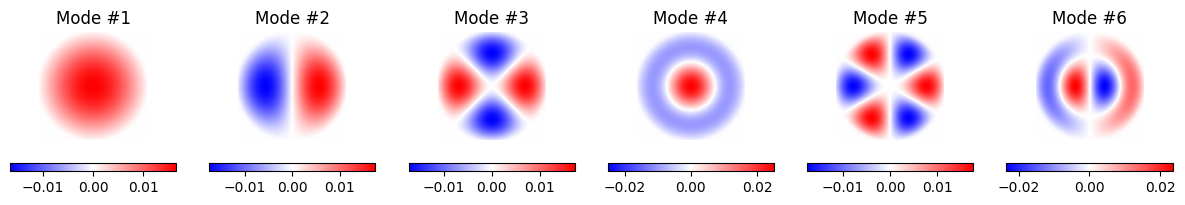

In [5]:
plt.figure(figsize=(15, 2))

max_modes = 6

for i in range(max_modes):
    plt.subplot(1, max_modes, i+1)
    mode = fiber._modes[:, :, 0, i]
    plt.imshow(mode, cmap='bwr', vmin=-np.max(np.abs(mode)), vmax=+np.max(np.abs(mode)))
    plt.axis('off')
    plt.title(f'Mode #{i+1}')
    plt.colorbar(orientation='horizontal')

### Define fitness and helpful functions

In [102]:
from waveoptics.metrics.numpy import quality, pearson
from waveoptics.plots.plots import complex_to_hsv

import torch
from torch.nn import AdaptiveAvgPool2d, UpsamplingNearest2d


class PartitionnedModeController:

    def __init__(self, dm_1d_acts, grid, target_field: np.ndarray, mode_index: int, fiber, fiber_length: float = 1.0, fitness_type: str = 'pearson'):
        self.dm_1d_acts = dm_1d_acts
        self.grid = grid
        self.target_field = target_field
        self.mode_index = mode_index
        self.fiber = fiber
        self.fiber_length = fiber_length
        self.fitness_type = fitness_type.lower()
        self.make_diagonal_mode_coupling_matrix()

    def make_diagonal_mode_coupling_matrix(self) -> np.ndarray:
        prop_constants = self.fiber._prop_constants.copy() # Columns with beta, n_eff, n, m, u, w
        print(prop_constants.shape)

        degen_betas = np.zeros(shape=(self.fiber._N_modes_degen))
        k = 0
        for i in range(fiber._N_modes):
            if prop_constants[i, 2] == 0: # Mode is centro-symmetric
                degen_betas[k] = prop_constants[i, 0]
                k += 1
            else: # Mode is not centro-symmetric
                degen_betas[k] = prop_constants[i, 0]
                degen_betas[k+1] = prop_constants[i, 0]
                k += 2

        self.propagation_matrix = np.diag(np.exp(-1j * degen_betas * self.fiber_length))


    def compute_output_field(self, x_reim):
        self.dm_field = self.generate_partitionned_cplx_input_beam(x_reim)
        self.coupled_in = StepIndexFiberDegenCoupler(self.dm_field, self.grid, self.fiber, N_modes=self.fiber._N_modes_degen)
        self.coupled_out = self.propagate(self.coupled_in)

    def generate_partitionned_cplx_input_beam(self, x_reim) -> np.ndarray:
        n2 = x_reim.size
        re_map = x_reim[:n2//2]
        im_map = x_reim[n2//2:]
        n = int(np.sqrt(x_reim.size // 2))

        cplx_map = re_map.reshape(n, n) + 1j * im_map.reshape(n, n)
        upsampler = UpsamplingNearest2d(size=self.target_field.shape)

        with torch.no_grad():
            upsampled = (
                upsampler(torch.from_numpy(np.real(cplx_map[np.newaxis, np.newaxis, ...])))
                + 1j * upsampler(torch.from_numpy(np.imag(cplx_map[np.newaxis, np.newaxis, ...])))
            )

        return upsampled.squeeze().cpu().numpy()
    
    def propagate(self, coupled_in) -> np.ndarray:
        new_coeffs = self.propagation_matrix @ coupled_in.modes_coeffs

        coupled_out = deepcopy(coupled_in)
        coupled_out.modes_coeffs = new_coeffs
        coupled_out.recompose()

        return coupled_out
    

    def fitness_cplx(self, x_reim):
        self.compute_output_field(x_reim)

        if self.fitness_type == 'pearson':
            self.loss = -pearson(np.square(np.abs(self.coupled_out.field)), np.square(np.abs(self.target_field)))
        elif self.fitness_type == 'quality':
            self.loss = -quality(self.coupled_out.field / np.max(np.abs(self.coupled_out.field)), self.target_field / np.max(np.abs(self.target_field)), squared=True)
        elif self.fitness_type == 'coeff':
            self.loss = -np.square(np.abs(self.coupled_out.modes_coeffs[self.mode_index]))
        else:
            self.loss = -pearson(np.square(np.abs(self.coupled_out.field)), np.square(np.abs(self.target_field)))

        return self.loss
    

    def plot_results(self):
        pear = pearson(np.square(np.abs(self.coupled_out.field)), np.square(np.abs(self.target_field)))
        qual = quality(self.coupled_out.field / np.max(np.abs(self.coupled_out.field)), self.target_field / np.max(np.abs(self.target_field)), squared=True)
        print(f"Best value: {self.loss}")
        print(f"Pearson intensity: {pear}")
        print(f"Quality squared: {qual}")


        plt.figure(figsize=(15, 8))

        plt.subplot(2, 4, 1)
        plt.imshow(complex_to_hsv(self.dm_field))
        plt.axis('off')
        plt.title('DM field')

        plt.subplot(2, 4, 2)
        plt.imshow(complex_to_hsv(self.coupled_in.field))
        plt.axis('off')
        plt.title('Input field')

        plt.subplot(2, 4, 3)
        plt.imshow(complex_to_hsv(self.coupled_out.field))
        plt.axis('off')
        plt.title('Output field')

        plt.subplot(2, 4, 4)
        plt.imshow(complex_to_hsv(self.target_field))
        plt.axis('off')
        plt.title('Target field')

        plt.subplot(2, 4, 6)
        plt.imshow(np.square(np.abs(self.coupled_in.field)), cmap='gray', vmin=0)
        plt.axis('off')
        plt.title('Input intensity')

        plt.subplot(2, 4, 7)
        plt.imshow(np.square(np.abs(self.coupled_out.field)), cmap='gray', vmin=0)
        plt.axis('off')
        plt.title('Output intensity')

        plt.subplot(2, 4, 8)
        plt.imshow(np.square(np.abs(self.target_field)), cmap='gray', vmin=0)
        plt.axis('off')
        plt.title('Target intensity')

        self.coupled_out.show_coefficients(as_heatmap=True)



### Optimize using CMA-ES from Nevergrad

(140, 6)


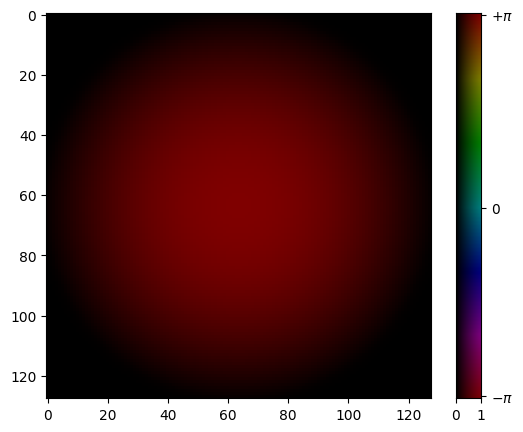

In [108]:
from waveoptics.plots.plots import complex_imshow
from scipy.ndimage import gaussian_filter

n = 8
mode_index = 0
target_field = np.complex64(fiber._modes[:, :, 1, mode_index])
complex_imshow(target_field)

controller = PartitionnedModeController(
    dm_1d_acts=n,
    grid=grid,
    target_field=target_field,
    mode_index=mode_index,
    fiber=fiber,
    fiber_length=1.0,
    fitness_type='coeff',
)

In [ ]:
import cma

# x0 = 1 / np.sqrt(2) * np.random.rand(2*n**2)
x0 = np.ones(shape=(n**2)) * np.exp(1j * 2 * np.pi * np.random.rand(n**2))
x0 = np.concatenate([np.real(x0), np.imag(x0)])
ub = 1.0
lb = -1.0

es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=1/3,
    options={
        'bounds': [lb, ub],
        # 'popsize': 20,
    },
)

es.optimize(controller.fitness_cplx, iterations=50)
# Get best solution and show it
best_solution = es.result.xbest 
best_value = es.result.fbest
best_eval = es.result.evals_best
fevals = es.result.evaluations

print(f"fevals={fevals}, best_value={best_value}, best_eval={best_eval}")

# plt.imshow(np.square(get_amplitude_from_phases(best_solution, TM, m)))

(9_w,18)-aCMA-ES (mu_w=5.4,w_1=30%) in dimension 128 (seed=189768, Mon May 12 15:18:37 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     18 -4.160959291148680e-02 1.0e+00 3.22e-01  3e-01  3e-01 0:03.4
    2     36 -4.727010026459699e-02 1.0e+00 3.14e-01  3e-01  3e-01 0:06.6
    3     54 -6.969469931358190e-02 1.0e+00 3.07e-01  3e-01  3e-01 0:09.9
    4     72 -7.298149722477310e-02 1.0e+00 3.01e-01  3e-01  3e-01 0:13.1
    6    108 -1.290340931556644e-01 1.0e+00 2.94e-01  3e-01  3e-01 0:19.6
    8    144 -1.519893323577311e-01 1.0e+00 2.90e-01  3e-01  3e-01 0:26.1
   10    180 -2.135627782901119e-01 1.0e+00 2.89e-01  3e-01  3e-01 0:32.6
   13    234 -2.893675394473272e-01 1.1e+00 2.90e-01  3e-01  3e-01 0:42.6
   16    288 -4.102933301257128e-01 1.1e+00 2.97e-01  3e-01  3e-01 0:52.5
   19    342 -4.314345216273391e-01 1.1e+00 3.05e-01  3e-01  3e-01 1:02.1


Best value: -0.015927481624784516
Pearson intensity: 0.28775695819933156
Quality squared: 0.0379867633051733


c:\users\saucourt\coding\mmf_lp_modes\mmfsim\speckle.py:383: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_fmt = pivot.applymap(lambda x: f"{x:.1e}" if pd.notnull(x) else "")


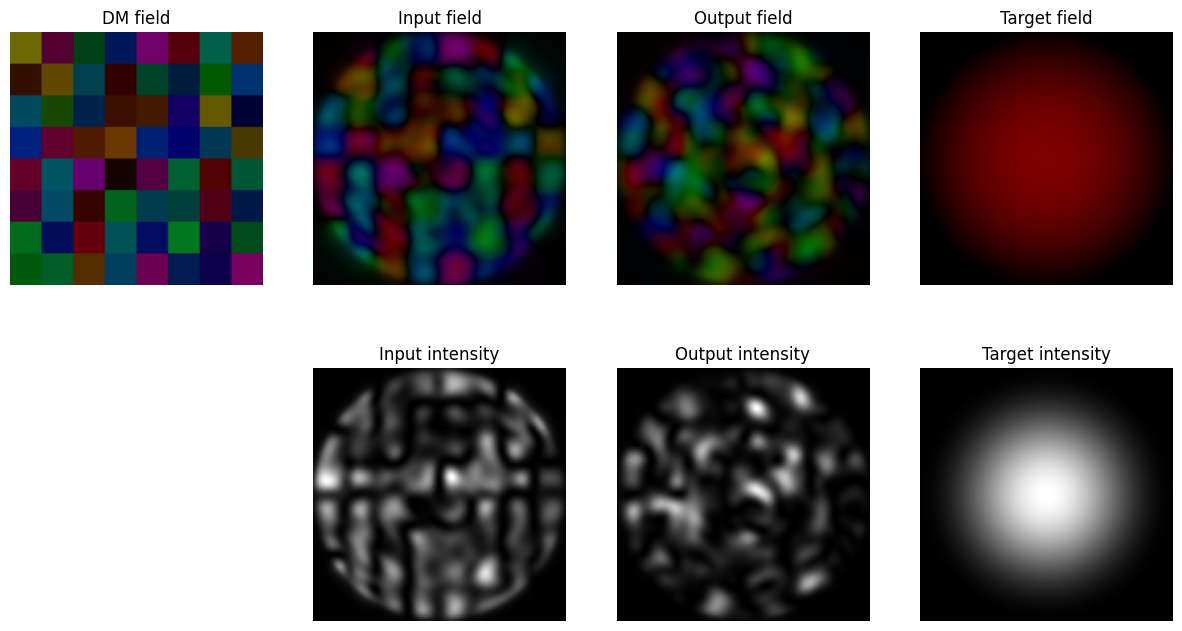

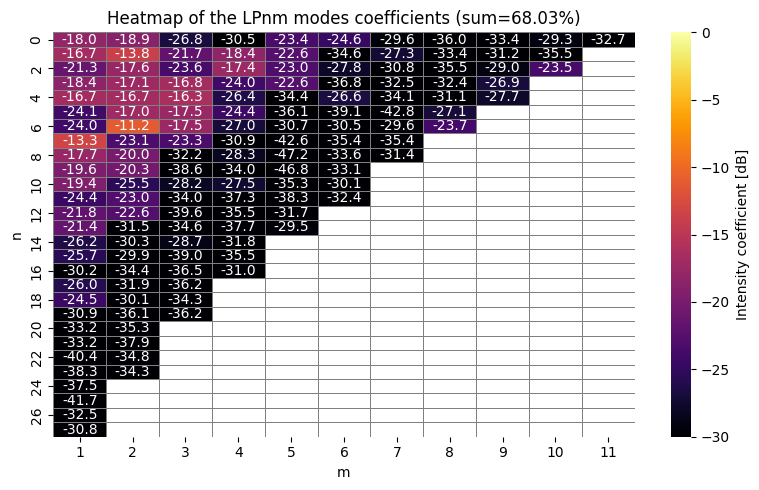

In [107]:
controller.fitness_cplx(x_reim=best_solution)
controller.plot_results()

Now let's create the propagation matrix with no mode energy exchange, this matrix is diagonal.
Then compute the new modes coefficients. Only their phases should have changed.

### Fourier transform the output speckle after padding it

(2048, 2048)
(2048, 2048)


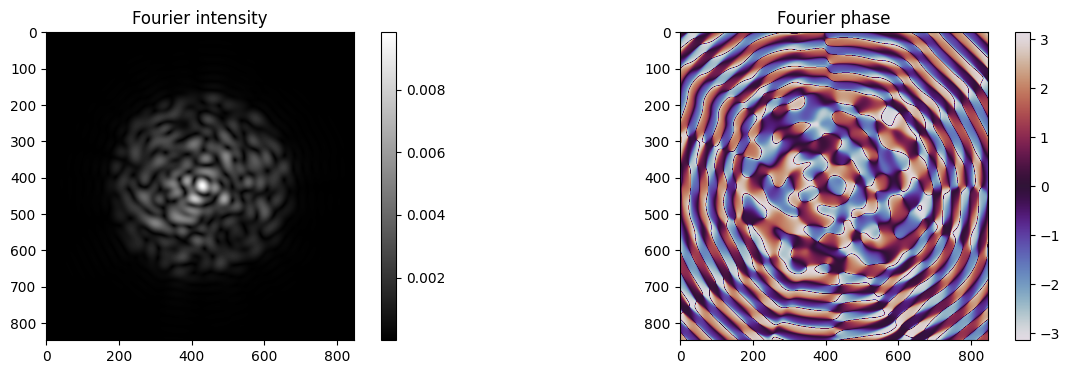

In [ ]:
speckle = controller.coupled_out.field
pad_amount = (grid_length_fourier - grid_length) // 2
padded_speckle = np.pad(speckle, pad_width=pad_amount)
print(padded_speckle.shape)

speckle_fourier = fourier_transform(padded_speckle)
print(speckle_fourier.shape)

win = slice(600, -600)

fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].set_title('Fourier intensity')
pl0 = axs[0].imshow(np.abs(speckle_fourier[win, win]), cmap='gray')
plt.colorbar(pl0, ax=axs[0])

axs[1].set_title('Fourier phase')
pl1 = axs[1].imshow(np.angle(speckle_fourier[win, win]), cmap='twilight')
plt.colorbar(pl1, ax=axs[1])